# Loading dependencies

In [1]:
###Reyes, Marcus Group 7

###CoE 197Z Project 1.1

import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,BatchNormalization
from keras import regularizers
from keras.optimizers import adam,sgd
from keras import optimizers

import numpy as np
from numpy import genfromtxt

from sklearn import preprocessing

import matplotlib.pyplot as plt

import string

from sixfunctions import load_train, load_x_test, clean_data_with_mean, recall_m,precision_m

print("Done importing")

Using TensorFlow backend.


Done importing


In [2]:
#[reason] / dup == duplicate
                  #unique      #dup of loc, numerous     #messy numerous
do_not_include = ['wpt_name', 'subvillage',             'scheme_name',

                 #uniform value     #Duplicate of payment type   #Dup of quantity
                 'recorded_by',     'payment',                  'quantity_group',
                 
                 #dup of wtptype less data      #dup of source  #dup of extr_type_group
                 'waterpoint_type_group',       'source_type',  'extraction_type',      'extraction_type_group',
                 
                 #enc in regcode
                 'region']

#These are sort of ordinal data
do_not_one_hot = ['id','gps_height','date_recorded','longitude','latitude','population','amount_tsh']

clean_up = ['population','amount_tsh']

#Tentatively do not include.
do_not_include_tent = ['funder','installer','ward','lga']

#Don't know what it means 
do_not_include_temp = ['num_private']

x, train_col,y = load_train("train_set_values.csv","train_set_labels.csv", do_not_include, do_not_one_hot, clean_up, do_not_include_tent, do_not_include_temp)

uniqueValues, occurCount = np.unique(y, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)
print("Done loading data")

Index(['id', 'status_group'], dtype='object') pre
Index(['id', 'status_group_functional', 'status_group_functional needs repair',
       'status_group_non functional'],
      dtype='object') post
About to clean up
About to clean up


C:\Users\Marcus\197_proj1\CoE197Z\sixfunctions.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_recorded'][i] = int(data['date_recorded'][i].replace("-","")[2:6])


Expanded basin Change 23 32
Expanded region_code Change 32 59
Expanded district_code Change 59 79
Expanded public_meeting Change 79 81
Expanded scheme_management Change 81 93
Expanded permit Change 93 95
Expanded construction_year Change 95 150
Expanded extraction_type_class Change 150 157
Expanded management Change 157 169
Expanded management_group Change 169 174
Expanded payment_type Change 174 181
Expanded water_quality Change 181 189
Expanded quality_group Change 189 195
Expanded quantity Change 195 200
Expanded source Change 200 210
Expanded source_class Change 210 213
Expanded waterpoint_type Change 213 220
Unique Values :  [0 1]
Occurrence Count :  [118800  59400]
Done loading data


In [3]:
print(y.shape)

(59400, 3)


In [14]:
###Model

hidden = 1024
dropout = 0.4

(trash, input_dim) = x.shape

activation = 'relu'

model = Sequential()


model.add(Dense(hidden, input_dim = input_dim))
model.add(Dropout(dropout))
model.add(Activation(activation))

model.add(Dense(hidden, input_dim = input_dim))
model.add(Dropout(dropout))
model.add(Activation(activation))


model.add(Dense(hidden, input_dim = input_dim))
model.add(Dropout(dropout))
model.add(Activation(activation))


model.add(Dense(3,input_dim = hidden))
model.add(Activation('softmax'))

#model.summary
adam = optimizers.Adam(lr=0.00025, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])


max_score = -1
iter_of_max = 0,0
train_plot = []
val_plot = []
x_axis = []

#Save the weights for k-fold validation
model.save_weights('model.h5')

amount = 200
k_folds = 4

###When i use k_folds instead of 10 for the np.zeros initialization it acts up
val_plot = np.zeros((k_folds,amount))
train_plot = np.zeros((k_folds,amount))
test_plot = np.zeros((k_folds,amount)) 
x_axis = np.zeros((k_folds,amount))
total = int(x.shape[0])
print(total)
precision_plot0 = np.zeros((k_folds,amount))
recall_plot0 = np.zeros((k_folds,amount))

precision_plot1 = np.zeros((k_folds,amount))
recall_plot1 = np.zeros((k_folds,amount))

precision_plot2 = np.zeros((k_folds,amount))
recall_plot2 = np.zeros((k_folds,amount))

print("Done setting up for fitting")

59400
Done setting up for fitting


In [15]:

for j in range(k_folds):

    whole = np.arange(0,total)
    test_range = np.arange((j)*(total/k_folds), (j)*(total/k_folds)+(total/k_folds),dtype = 'int')
    
    train_range = np.delete(whole, test_range)
    
    
    #K-fold validation setup
    x_train = x[train_range,:]
    x_pretest = x[test_range,:]
    y_train = y[train_range,:]
    y_pretest = y[test_range,:]
    print(test_range)
    print(train_range)
    
    for i in range(amount):

        history = model.fit(x_train, y_train, epochs = 1, batch_size = 4096*4, verbose = 0)
        score,accuracy = model.evaluate(x_pretest, y_pretest, batch_size = 512, verbose = 0)
        
        y_pred = model.predict(x_pretest)
        y_pred = np.argmax(y_pred, axis = 1)
        #y_pred = status.reshape(y_true.shape)
        y_true = np.argmax(y_pretest,axis = 1)
        precision0 = (precision_m(y_true,y_pred))
        recall0 = (recall_m(y_true, y_pred))
        if  float(100 * accuracy) > float(max_score):
            max_score = float(100 * accuracy)
            iter_of_max = i,j
        if i%1 == 0:
            print("----------",i,"-",j,"-----------")
            print("Test accuracy: ", (100.0 * accuracy))
            print("Maxscore: ", max_score, "at", iter_of_max,"epoch-kthfold")
        
        #for the plot
        x_axis[j,i] = i
        test_plot[j,i] = (accuracy)
        train_plot[j,i] = np.array(history.history['acc'])
        precision_plot0[j,i] = precision0[0]
        recall_plot0[j,i] = recall0[0]
        precision_plot1[j,i] = precision0[1]
        recall_plot1[j,i] = recall0[1]
        precision_plot2[j,i] = precision0[2]
        recall_plot2[j,i] = recall0[2]
        
        predictions = (y_pred == 0).sum(),(y_pred == 1).sum(),(y_pred == 2).sum()
        correct = (y_true == 0).sum(),(y_true == 1).sum(), (y_true == 2).sum()
        print(predictions, "Predictions")
        print(correct, "correct")
        #print(precision0[0],"Precision0")
        #print(recall0[0],"Recall0")

    if j == k_folds - 1:
        break
    model.load_weights('model.h5')
    print("Reloading Model")
    
print("Done evaluating performance")

[    0     1     2 ... 14847 14848 14849]
[14850 14851 14852 ... 59397 59398 59399]
---------- 0 - 0 -----------
Test accuracy:  54.329966329966325
Maxscore:  54.329966329966325 at (0, 0) epoch-kthfold
(14850, 0, 0) Predictions
(8068, 1090, 5692) correct
---------- 1 - 0 -----------
Test accuracy:  62.18181818181818
Maxscore:  62.18181818181818 at (1, 0) epoch-kthfold
(13407, 0, 1443) Predictions
(8068, 1090, 5692) correct
---------- 2 - 0 -----------
Test accuracy:  66.06734006734007
Maxscore:  66.06734006734007 at (2, 0) epoch-kthfold
(12195, 0, 2655) Predictions
(8068, 1090, 5692) correct
---------- 3 - 0 -----------
Test accuracy:  67.7979797979798
Maxscore:  67.7979797979798 at (3, 0) epoch-kthfold
(11793, 0, 3057) Predictions
(8068, 1090, 5692) correct
---------- 4 - 0 -----------
Test accuracy:  69.52188552188552
Maxscore:  69.52188552188552 at (4, 0) epoch-kthfold
(10630, 0, 4220) Predictions
(8068, 1090, 5692) correct
---------- 5 - 0 -----------
Test accuracy:  70.38383838383

---------- 47 - 0 -----------
Test accuracy:  78.11447811447812
Maxscore:  78.11447811447812 at (47, 0) epoch-kthfold
(9235, 588, 5027) Predictions
(8068, 1090, 5692) correct
---------- 48 - 0 -----------
Test accuracy:  78.02020202020202
Maxscore:  78.11447811447812 at (47, 0) epoch-kthfold
(9185, 618, 5047) Predictions
(8068, 1090, 5692) correct
---------- 49 - 0 -----------
Test accuracy:  78.0942760942761
Maxscore:  78.11447811447812 at (47, 0) epoch-kthfold
(9343, 583, 4924) Predictions
(8068, 1090, 5692) correct
---------- 50 - 0 -----------
Test accuracy:  78.18855218855218
Maxscore:  78.18855218855218 at (50, 0) epoch-kthfold
(9122, 587, 5141) Predictions
(8068, 1090, 5692) correct
---------- 51 - 0 -----------
Test accuracy:  78.24915824915824
Maxscore:  78.24915824915824 at (51, 0) epoch-kthfold
(9386, 566, 4898) Predictions
(8068, 1090, 5692) correct
---------- 52 - 0 -----------
Test accuracy:  78.22222222222223
Maxscore:  78.24915824915824 at (51, 0) epoch-kthfold
(9214, 6

---------- 94 - 0 -----------
Test accuracy:  79.1986531986532
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9145, 662, 5043) Predictions
(8068, 1090, 5692) correct
---------- 95 - 0 -----------
Test accuracy:  79.05723905723906
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8846, 690, 5314) Predictions
(8068, 1090, 5692) correct
---------- 96 - 0 -----------
Test accuracy:  78.98989898989899
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9164, 658, 5028) Predictions
(8068, 1090, 5692) correct
---------- 97 - 0 -----------
Test accuracy:  78.96296296296296
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8935, 671, 5244) Predictions
(8068, 1090, 5692) correct
---------- 98 - 0 -----------
Test accuracy:  78.96969696969697
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9074, 690, 5086) Predictions
(8068, 1090, 5692) correct
---------- 99 - 0 -----------
Test accuracy:  78.92255892255892
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8926, 708, 52

---------- 141 - 0 -----------
Test accuracy:  78.52525252525253
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8715, 782, 5353) Predictions
(8068, 1090, 5692) correct
---------- 142 - 0 -----------
Test accuracy:  78.5925925925926
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8776, 732, 5342) Predictions
(8068, 1090, 5692) correct
---------- 143 - 0 -----------
Test accuracy:  78.61952861952862
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8762, 746, 5342) Predictions
(8068, 1090, 5692) correct
---------- 144 - 0 -----------
Test accuracy:  78.7070707070707
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8849, 772, 5229) Predictions
(8068, 1090, 5692) correct
---------- 145 - 0 -----------
Test accuracy:  78.5925925925926
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8689, 762, 5399) Predictions
(8068, 1090, 5692) correct
---------- 146 - 0 -----------
Test accuracy:  78.61952861952862
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8810, 733

---------- 188 - 0 -----------
Test accuracy:  78.11447811447812
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8598, 813, 5439) Predictions
(8068, 1090, 5692) correct
---------- 189 - 0 -----------
Test accuracy:  78.26936026936026
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8862, 794, 5194) Predictions
(8068, 1090, 5692) correct
---------- 190 - 0 -----------
Test accuracy:  78.0942760942761
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8613, 785, 5452) Predictions
(8068, 1090, 5692) correct
---------- 191 - 0 -----------
Test accuracy:  78.3973063973064
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8858, 783, 5209) Predictions
(8068, 1090, 5692) correct
---------- 192 - 0 -----------
Test accuracy:  78.04040404040404
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8596, 824, 5430) Predictions
(8068, 1090, 5692) correct
---------- 193 - 0 -----------
Test accuracy:  78.32996632996633
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8849, 78

---------- 35 - 1 -----------
Test accuracy:  77.15824915824916
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9729, 369, 4752) Predictions
(8102, 1066, 5682) correct
---------- 36 - 1 -----------
Test accuracy:  77.05050505050505
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9603, 393, 4854) Predictions
(8102, 1066, 5682) correct
---------- 37 - 1 -----------
Test accuracy:  77.2121212121212
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9708, 391, 4751) Predictions
(8102, 1066, 5682) correct
---------- 38 - 1 -----------
Test accuracy:  77.05723905723906
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9556, 426, 4868) Predictions
(8102, 1066, 5682) correct
---------- 39 - 1 -----------
Test accuracy:  77.12457912457913
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9555, 439, 4856) Predictions
(8102, 1066, 5682) correct
---------- 40 - 1 -----------
Test accuracy:  77.11111111111111
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9537, 461, 48

---------- 83 - 1 -----------
Test accuracy:  78.23569023569024
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9082, 692, 5076) Predictions
(8102, 1066, 5682) correct
---------- 84 - 1 -----------
Test accuracy:  78.24242424242425
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9059, 740, 5051) Predictions
(8102, 1066, 5682) correct
---------- 85 - 1 -----------
Test accuracy:  78.27609427609428
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8924, 731, 5195) Predictions
(8102, 1066, 5682) correct
---------- 86 - 1 -----------
Test accuracy:  78.28282828282829
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9096, 696, 5058) Predictions
(8102, 1066, 5682) correct
---------- 87 - 1 -----------
Test accuracy:  78.0942760942761
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8879, 769, 5202) Predictions
(8102, 1066, 5682) correct
---------- 88 - 1 -----------
Test accuracy:  78.28282828282829
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8986, 775, 50

---------- 130 - 1 -----------
Test accuracy:  78.81481481481481
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8860, 861, 5129) Predictions
(8102, 1066, 5682) correct
---------- 131 - 1 -----------
Test accuracy:  78.77441077441077
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8845, 859, 5146) Predictions
(8102, 1066, 5682) correct
---------- 132 - 1 -----------
Test accuracy:  78.92255892255892
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8868, 811, 5171) Predictions
(8102, 1066, 5682) correct
---------- 133 - 1 -----------
Test accuracy:  78.74747474747474
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8744, 851, 5255) Predictions
(8102, 1066, 5682) correct
---------- 134 - 1 -----------
Test accuracy:  78.84175084175085
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8813, 868, 5169) Predictions
(8102, 1066, 5682) correct
---------- 135 - 1 -----------
Test accuracy:  78.72053872053873
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8694, 

---------- 177 - 1 -----------
Test accuracy:  78.65319865319866
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8778, 877, 5195) Predictions
(8102, 1066, 5682) correct
---------- 178 - 1 -----------
Test accuracy:  78.4983164983165
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8589, 946, 5315) Predictions
(8102, 1066, 5682) correct
---------- 179 - 1 -----------
Test accuracy:  78.5925925925926
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8778, 882, 5190) Predictions
(8102, 1066, 5682) correct
---------- 180 - 1 -----------
Test accuracy:  78.55892255892256
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8767, 876, 5207) Predictions
(8102, 1066, 5682) correct
---------- 181 - 1 -----------
Test accuracy:  78.44444444444446
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8640, 956, 5254) Predictions
(8102, 1066, 5682) correct
---------- 182 - 1 -----------
Test accuracy:  78.61279461279462
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8661, 89

---------- 24 - 2 -----------
Test accuracy:  75.98653198653199
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9921, 111, 4818) Predictions
(8070, 1063, 5717) correct
---------- 25 - 2 -----------
Test accuracy:  76.18181818181819
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9976, 115, 4759) Predictions
(8070, 1063, 5717) correct
---------- 26 - 2 -----------
Test accuracy:  76.22895622895622
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9870, 128, 4852) Predictions
(8070, 1063, 5717) correct
---------- 27 - 2 -----------
Test accuracy:  76.3097643097643
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9916, 131, 4803) Predictions
(8070, 1063, 5717) correct
---------- 28 - 2 -----------
Test accuracy:  76.41077441077441
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9855, 147, 4848) Predictions
(8070, 1063, 5717) correct
---------- 29 - 2 -----------
Test accuracy:  76.42424242424242
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9810, 185, 48

---------- 72 - 2 -----------
Test accuracy:  78.47811447811448
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9115, 684, 5051) Predictions
(8070, 1063, 5717) correct
---------- 73 - 2 -----------
Test accuracy:  78.32996632996633
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9097, 654, 5099) Predictions
(8070, 1063, 5717) correct
---------- 74 - 2 -----------
Test accuracy:  78.32323232323233
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9098, 664, 5088) Predictions
(8070, 1063, 5717) correct
---------- 75 - 2 -----------
Test accuracy:  78.37710437710437
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9038, 692, 5120) Predictions
(8070, 1063, 5717) correct
---------- 76 - 2 -----------
Test accuracy:  78.3838383838384
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9079, 684, 5087) Predictions
(8070, 1063, 5717) correct
---------- 77 - 2 -----------
Test accuracy:  78.37037037037037
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8946, 705, 51

---------- 120 - 2 -----------
Test accuracy:  78.32323232323233
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8867, 750, 5233) Predictions
(8070, 1063, 5717) correct
---------- 121 - 2 -----------
Test accuracy:  78.41750841750842
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8893, 773, 5184) Predictions
(8070, 1063, 5717) correct
---------- 122 - 2 -----------
Test accuracy:  78.30303030303031
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8797, 813, 5240) Predictions
(8070, 1063, 5717) correct
---------- 123 - 2 -----------
Test accuracy:  78.34343434343435
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8809, 820, 5221) Predictions
(8070, 1063, 5717) correct
---------- 124 - 2 -----------
Test accuracy:  78.32323232323233
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8760, 817, 5273) Predictions
(8070, 1063, 5717) correct
---------- 125 - 2 -----------
Test accuracy:  78.44444444444446
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8899, 

---------- 167 - 2 -----------
Test accuracy:  78.42424242424244
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8776, 857, 5217) Predictions
(8070, 1063, 5717) correct
---------- 168 - 2 -----------
Test accuracy:  78.30303030303031
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8663, 803, 5384) Predictions
(8070, 1063, 5717) correct
---------- 169 - 2 -----------
Test accuracy:  78.45791245791246
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8904, 844, 5102) Predictions
(8070, 1063, 5717) correct
---------- 170 - 2 -----------
Test accuracy:  77.83164983164983
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8460, 910, 5480) Predictions
(8070, 1063, 5717) correct
---------- 171 - 2 -----------
Test accuracy:  78.45117845117845
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8816, 823, 5211) Predictions
(8070, 1063, 5717) correct
---------- 172 - 2 -----------
Test accuracy:  78.11447811447812
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8657, 

---------- 14 - 3 -----------
Test accuracy:  74.36363636363636
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(10274, 0, 4576) Predictions
(8019, 1098, 5733) correct
---------- 15 - 3 -----------
Test accuracy:  74.37037037037038
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(10215, 0, 4635) Predictions
(8019, 1098, 5733) correct
---------- 16 - 3 -----------
Test accuracy:  74.5050505050505
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(10272, 0, 4578) Predictions
(8019, 1098, 5733) correct
---------- 17 - 3 -----------
Test accuracy:  74.67340067340066
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(10219, 0, 4631) Predictions
(8019, 1098, 5733) correct
---------- 18 - 3 -----------
Test accuracy:  74.66666666666667
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(10310, 5, 4535) Predictions
(8019, 1098, 5733) correct
---------- 19 - 3 -----------
Test accuracy:  74.92255892255892
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(10156, 19, 4675) P

---------- 62 - 3 -----------
Test accuracy:  77.65656565656566
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9143, 610, 5097) Predictions
(8019, 1098, 5733) correct
---------- 63 - 3 -----------
Test accuracy:  77.67003367003366
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9141, 655, 5054) Predictions
(8019, 1098, 5733) correct
---------- 64 - 3 -----------
Test accuracy:  77.54208754208754
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9065, 677, 5108) Predictions
(8019, 1098, 5733) correct
---------- 65 - 3 -----------
Test accuracy:  77.63636363636364
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9134, 677, 5039) Predictions
(8019, 1098, 5733) correct
---------- 66 - 3 -----------
Test accuracy:  77.75084175084174
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9054, 668, 5128) Predictions
(8019, 1098, 5733) correct
---------- 67 - 3 -----------
Test accuracy:  77.73737373737374
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9111, 665, 5

---------- 110 - 3 -----------
Test accuracy:  78.94949494949495
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8906, 823, 5121) Predictions
(8019, 1098, 5733) correct
---------- 111 - 3 -----------
Test accuracy:  78.85521885521885
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8863, 791, 5196) Predictions
(8019, 1098, 5733) correct
---------- 112 - 3 -----------
Test accuracy:  78.91582491582491
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8968, 844, 5038) Predictions
(8019, 1098, 5733) correct
---------- 113 - 3 -----------
Test accuracy:  78.78114478114479
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8764, 794, 5292) Predictions
(8019, 1098, 5733) correct
---------- 114 - 3 -----------
Test accuracy:  78.97643097643098
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(9057, 782, 5011) Predictions
(8019, 1098, 5733) correct
---------- 115 - 3 -----------
Test accuracy:  78.72727272727272
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8721, 

---------- 157 - 3 -----------
Test accuracy:  78.55218855218855
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8533, 939, 5378) Predictions
(8019, 1098, 5733) correct
---------- 158 - 3 -----------
Test accuracy:  78.55892255892256
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8793, 928, 5129) Predictions
(8019, 1098, 5733) correct
---------- 159 - 3 -----------
Test accuracy:  78.57239057239057
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8651, 916, 5283) Predictions
(8019, 1098, 5733) correct
---------- 160 - 3 -----------
Test accuracy:  78.41750841750842
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8670, 968, 5212) Predictions
(8019, 1098, 5733) correct
---------- 161 - 3 -----------
Test accuracy:  78.5925925925926
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8602, 906, 5342) Predictions
(8019, 1098, 5733) correct
---------- 162 - 3 -----------
Test accuracy:  78.63299663299664
Maxscore:  79.1986531986532 at (94, 0) epoch-kthfold
(8784, 8

# Plotting the Training Accuracy vs the Test Accuracy

Test(Blue) and Training(Yellow) Accuracy


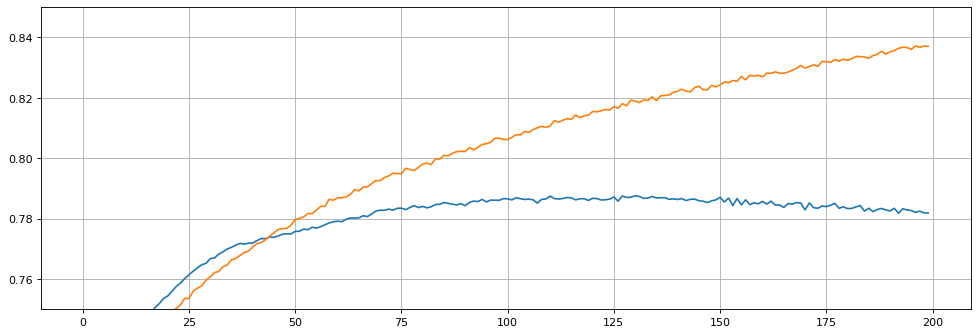

-----------------------------------------------------------
Precision(Blue) and Recall(Yellow) for category: Functional


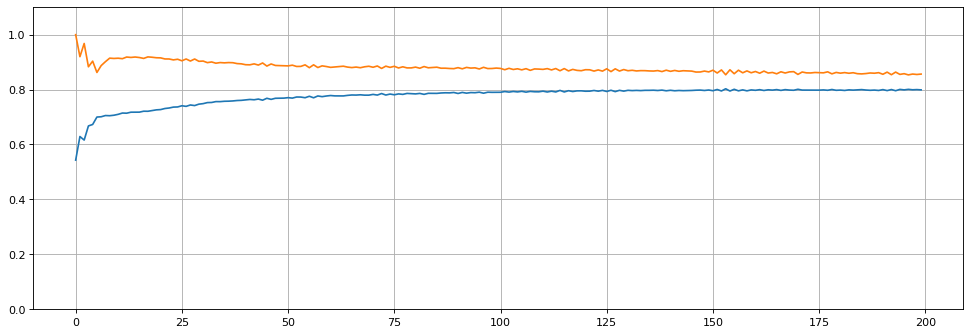

-----------------------------------------------------------
Precision(Blue) and Recall(Yellow) for category: Functional Needs Repair


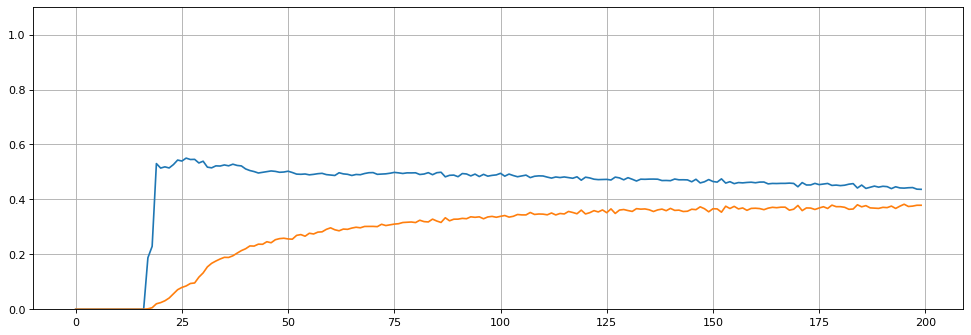

-----------------------------------------------------------
Precision(Blue) and Recall(Yellow) for category: Non Functional


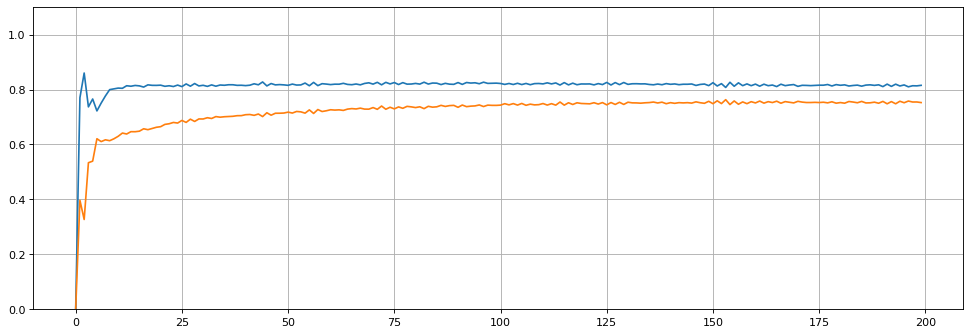

In [23]:
print("Test(Blue) and Training(Yellow) Accuracy")
plt.figure(num =0,figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()
axes.set_ylim([00.75,0.85])
plt.grid(which = 'both')
plt.plot(np.mean(test_plot[0:k_folds,:],axis = 0))
plt.plot(np.mean(train_plot[0:k_folds,:],axis = 0))
plt.draw()
plt.pause(0.001)
print("-----------------------------------------------------------")
print("Precision(Blue) and Recall(Yellow) for category: Functional")
plt.figure(num =1,figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()
axes.set_ylim([0.0,1.1])
plt.grid(which = 'both')
plt.plot(np.mean(precision_plot0[0:k_folds,:],axis = 0))
plt.plot(np.mean(recall_plot0[0:k_folds,:],axis = 0))
plt.draw()
plt.pause(0.001)


print("-----------------------------------------------------------")
print("Precision(Blue) and Recall(Yellow) for category: Functional Needs Repair")
plt.figure(num =2,figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()
axes.set_ylim([0.0,1.1])
plt.grid(which = 'both')
plt.plot(np.mean(precision_plot1[0:k_folds,:],axis = 0))
plt.plot(np.mean(recall_plot1[0:k_folds,:],axis = 0))
plt.draw()
plt.pause(0.001)


print("-----------------------------------------------------------")
print("Precision(Blue) and Recall(Yellow) for category: Non Functional")
plt.figure(num =3,figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()
axes.set_ylim([0.0,1.1])
plt.grid(which = 'both')
plt.plot(np.mean(precision_plot2[0:k_folds,:],axis = 0))
plt.plot(np.mean(recall_plot2[0:k_folds,:],axis = 0))
plt.draw()
plt.pause(0.001)




In [19]:

#Train one final time on the entire model
history = model.fit(x, y, epochs = 120, batch_size = 4096*4)
print("Done Training")

#Load the test data
x_test, test_col,data_id = load_x_test("test_set_values.csv",train_col, do_not_include, do_not_one_hot, clean_up, do_not_include_tent, do_not_include_temp)




#Make the predictions
y_pred = model.predict(x_test)
status = np.argmax(y_pred, axis = 1)
status = status.reshape(x_test.shape[0],1)
id = x_test[:,0].reshape(x_test.shape[0],1)
y_pred = np.concatenate((id,status), axis = 1)


#Format the submission
presub_id = pd.DataFrame(data_id)
presub_status = pd.DataFrame(status)
presub_status.replace({0:'functional',1:'functional needs repair',2:'non functional'}, inplace=True)
presubmission = pd.concat([presub_id,presub_status],axis = 1)
presubmission.iloc[:,0] = presubmission.iloc[:,0].astype(int)
presubmission.to_csv("submission_datadriven.csv",header = ["id", "status_group"],index = False)
print("Outputted csv file")

Epoch 1/120
59400/59400 [==============================] - 1s 13us/step - loss: 0.4294 - acc: 0.8248
Epoch 2/120
59400/59400 [==============================] - 1s 13us/step - loss: 0.4255 - acc: 0.8266
Epoch 3/120
59400/59400 [==============================] - 1s 13us/step - loss: 0.4249 - acc: 0.8251
Epoch 4/120
59400/59400 [==============================] - 1s 13us/step - loss: 0.4227 - acc: 0.8260
Epoch 5/120
59400/59400 [==============================] - 1s 13us/step - loss: 0.4212 - acc: 0.8264
Epoch 6/120
59400/59400 [==============================] - 1s 14us/step - loss: 0.4204 - acc: 0.8272
Epoch 7/120
59400/59400 [==============================] - 1s 14us/step - loss: 0.4213 - acc: 0.8251
Epoch 8/120
59400/59400 [==============================] - 1s 14us/step - loss: 0.4184 - acc: 0.8259
Epoch 9/120
59400/59400 [==============================] - 1s 13us/step - loss: 0.4179 - acc: 0.8262
Epoch 10/120
59400/59400 [==============================] - 1s 11us/step - loss: 0.4133 - a

C:\Users\Marcus\197_proj1\CoE197Z\sixfunctions.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_recorded'][i] = int(data['date_recorded'][i].replace("-","")[2:6])


Expanded basin Change 23 32
Expanded region_code Change 32 58
Expanded district_code Change 58 78
Expanded public_meeting Change 78 80
Expanded scheme_management Change 80 91
Expanded permit Change 91 93
Expanded construction_year Change 93 148
Expanded extraction_type_class Change 148 155
Expanded management Change 155 167
Expanded management_group Change 167 172
Expanded payment_type Change 172 179
Expanded water_quality Change 179 187
Expanded quality_group Change 187 193
Expanded quantity Change 193 198
Expanded source Change 198 208
Expanded source_class Change 208 211
Expanded waterpoint_type Change 211 218
Included region_code_40.0
Included scheme_management_None
Outputted csv file
